In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
DATASET_PATH = "/kaggle/input/edges2shoes/"

IMG_SIZE = 128
BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
from PIL import Image

class Pix2PixDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.files = sorted(os.listdir(root))
        self.root = root

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.files[idx])).convert("RGB")
        w, h = img.size

        edge = img.crop((0, 0, w//2, h))
        real = img.crop((w//2, 0, w, h))

        edge = transform(edge)
        real = transform(real)

        return edge, real

train_data = Pix2PixDataset("/kaggle/input/datasets/balraj98/edges2shoes-dataset/train")
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def down(in_c,out_c,norm=True):
    layers=[nn.Conv2d(in_c,out_c,4,2,1,bias=False)]
    if norm:
        layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def up(in_c,out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c,out_c,4,2,1,bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU()
    )

class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # 128 → 64 → 32 → 16 → 8 → 4
        self.d1=down(3,64,False)
        self.d2=down(64,128)
        self.d3=down(128,256)
        self.d4=down(256,512)
        self.d5=down(512,512)

        # 4 → 8 → 16 → 32 → 64 → 128
        self.u1=up(512,512)
        self.u2=up(1024,256)
        self.u3=up(512,128)
        self.u4=up(256,64)

        self.final=nn.Sequential(
            nn.ConvTranspose2d(128,3,4,2,1),
            nn.Tanh()
        )

    def forward(self,x):
        d1=self.d1(x)
        d2=self.d2(d1)
        d3=self.d3(d2)
        d4=self.d4(d3)
        d5=self.d5(d4)

        u1=self.u1(d5)
        u2=self.u2(torch.cat([u1,d4],1))
        u3=self.u3(torch.cat([u2,d3],1))
        u4=self.u4(torch.cat([u3,d2],1))

        return self.final(torch.cat([u4,d1],1))

In [11]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_c,out_c,norm=True):
            layers=[nn.Conv2d(in_c,out_c,4,2,1)]
            if norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model=nn.Sequential(
            *block(6,64,False),
            *block(64,128),
            *block(128,256),
            *block(256,512),
            nn.Conv2d(512,1,4,1,1)
        )

    def forward(self,edge,real):
        x=torch.cat([edge,real],1)
        return self.model(x)

In [12]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(3,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.ReLU(),
            nn.Conv2d(128,256,4,2,1), nn.ReLU()
        )

        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,3,4,2,1), nn.Tanh()
        )

    def forward(self,x):
        return self.decoder(self.encoder(x))

In [13]:
G=UNetGenerator().to(DEVICE)
D=PatchDiscriminator().to(DEVICE)
CNN=CNNBaseline().to(DEVICE)

adv_loss=nn.BCEWithLogitsLoss()
l1_loss=nn.L1Loss()

opt_G=optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
opt_D=optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
opt_CNN=optim.Adam(CNN.parameters(),lr=0.0002)

In [14]:
EPOCHS=5

for epoch in range(EPOCHS):
    for edge,real in train_loader:

        edge,real=edge.to(DEVICE),real.to(DEVICE)

        # ---- Train Generator ----
        opt_G.zero_grad()

        gen=G(edge)
        pred=D(edge,gen)

        valid=torch.ones_like(pred)

        g_loss=adv_loss(pred,valid)+100*l1_loss(gen,real)
        g_loss.backward()
        opt_G.step()

        # ---- Train Discriminator ----
        opt_D.zero_grad()

        pred_real=D(edge,real)
        valid=torch.ones_like(pred_real)
        real_loss=adv_loss(pred_real,valid)

        pred_fake=D(edge,gen.detach())
        fake=torch.zeros_like(pred_fake)
        fake_loss=adv_loss(pred_fake,fake)

        d_loss=(real_loss+fake_loss)/2
        d_loss.backward()
        opt_D.step()

    print("Epoch:",epoch,"G:",g_loss.item(),"D:",d_loss.item())

Epoch: 0 G: 17.620094299316406 D: 0.2693171203136444
Epoch: 1 G: 11.903776168823242 D: 0.42360445857048035
Epoch: 2 G: 20.060726165771484 D: 0.330991268157959
Epoch: 3 G: 7.051387786865234 D: 0.5243785977363586
Epoch: 4 G: 21.074195861816406 D: 0.4171021282672882


In [15]:
for epoch in range(3):
    for edge,real in train_loader:

        edge,real=edge.to(DEVICE),real.to(DEVICE)

        opt_CNN.zero_grad()
        out=CNN(edge)
        loss=l1_loss(out,real)
        loss.backward()
        opt_CNN.step()

    print("CNN Epoch:",epoch,"Loss:",loss.item())

CNN Epoch: 0 Loss: 0.16256414353847504
CNN Epoch: 1 Loss: 0.5584694743156433
CNN Epoch: 2 Loss: 0.3244043290615082


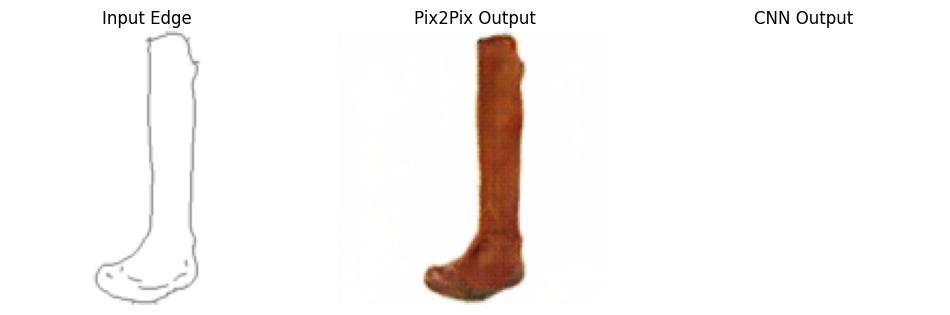

In [17]:
edge,real=next(iter(train_loader))
edge=edge.to(DEVICE)

with torch.no_grad():
    pix=G(edge)
    cnn=CNN(edge)

def show(x,title):
    x=(x[0].cpu()*0.5+0.5).permute(1,2,0)
    plt.imshow(x)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); show(edge,"Input Edge")
plt.subplot(1,3,2); show(pix,"Pix2Pix Output")
plt.subplot(1,3,3); show(cnn,"CNN Output")
plt.show()